# Extract Color Experiment

## Set Up Spotify API Tool

In [1]:
import spotipy
import spotipy.util as util

In [2]:
def get_spotify_object():
    CLIENT_ID = "528ce38cc4474085a235dd445394f1bd"
    CLIENT_SECRET = "6170bccae7f74a418222ff62cd4b92f5"

    token = util.oauth2.SpotifyClientCredentials(
        client_id = CLIENT_ID,
        client_secret = CLIENT_SECRET
    )

    cache_token = token.get_access_token()
    return spotipy.Spotify(cache_token)

## Search and Return Album Art

In [3]:
def get_albums():
    query = input("Search for an Album: ")
    
    spotify = get_spotify_object()
    results = spotify.search(
        q = query,
        type = "album",
        limit = "3"
    )

    if len(results["albums"]["items"]) == 0:
        print("No Albums Found, Please Try Again.\n")
        get_album_art()

    else:
        albums = []
        for i in range(len(results["albums"]["items"])):
            album_id = results["albums"]["items"][i]["id"]
            albums.append(spotify.album(album_id))
        
        return albums

## Extract Main Colors

In [4]:
from PIL import Image as PilImg
import requests
from io import BytesIO
import colorgram

In [5]:
def get_album_colors(album_art_url, num_of_colors):
    response = requests.get(album_art_url)
    img = PilImg.open(BytesIO(response.content))
    
    colors = colorgram.extract(img, num_of_colors)
    return colors

## Extract Color from Album

In [6]:
from flat import document, shape, rgba

In [11]:
def extract_color(album_art_url, color):
    response = requests.get(album_art_url)
    img = PilImg.open(BytesIO(response.content))
    pix = img.load()
    width = img.size[0]
    height = img.size[1]
    
    pixels = []
    for y in range(height):
        for x in range(width):
            rgb = pix[x, y]
            r = rgb[0]
            g = rgb[1]
            b = rgb[2]
            
            pixel = shape()
            pixel.nostroke()
            
            if color["r"] == r and color["g"] == g and color["b"] == b:
                pixel.fill(rgba(r, g, b, 255))
            
            else:
                d = ((color["r"]-r)*0.30)**2 + ((color["g"]-g)*0.59)**2 + ((color["b"]-b)*0.11)**2
                
                if d < 200:
                    pixel.fill(rgba(r, g, b, 255))
                    
                else:
                    pixel.fill(rgba(0, 0, 0, 0))
                
            rect = pixel.rectangle(x, y, 1, 1)
            pixels.append(rect)
                
    return pixels, width, height

## Finding Albums, Getting Main Colors

In [8]:
from IPython.display import Image, HTML, display

Search for an Album: because i was in love


Number of album you'd like to use: 2


Number of color to extract: 4


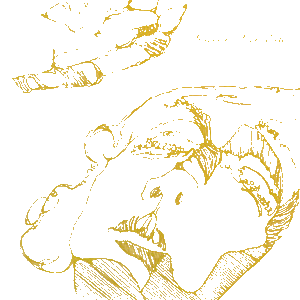

In [28]:
albums = get_albums()

albums_html = ""
album_art_urls = []
count = 1
for i in range(len(albums)):
    album_art_urls.append(albums[i]["images"][1]["url"])
    albums_html += '''
        <div style="margin-right: 5px;">
            <img src="''' + album_art_urls[i] + '''" />
            <p style="margin: 0; text-align: center;">''' + str(count) + '''</p>
        </div>
    '''
    count += 1
    
display(HTML("<div style='display: flex;'>" + albums_html + "</div>"))
album_number = int(input("Number of album you'd like to use: ")) - 1

album_colors = get_album_colors(album_art_urls[album_number], 10)
colors_html = ""
count = 1
for color in album_colors:
    colors_html += '''
        <div style="margin-right: 5px;">
            <div style="
                width: 50px;
                height: 50px;
                background-color: rgb(''' + str(color.rgb.r) + "," + str(color.rgb.g) + "," + str(color.rgb.b) + ''');
            "></div>
            <p style="margin: 0; text-align: center;">''' + str(count) + '''</p>
        </div>
    '''
    count += 1

display(HTML("<div style='display: flex;'>" + colors_html + "</div>"))
color_number = int(input("Number of color to extract: ")) - 1

color_to_extract = {
    "r": album_colors[color_number].rgb.r,
    "g": album_colors[color_number].rgb.g,
    "b": album_colors[color_number].rgb.b,
}
pixels, width, height = extract_color(album_art_urls[album_number], color_to_extract)

d = document(width, height, "pt")
page = d.addpage()

for pixel in pixels:
    page.place(pixel)
    
display(Image(page.image(kind="rgba").png()))